In [11]:
import os
import sys
import time
from typing import Dict, List, Iterable

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import torch
from datetime import datetime, timedelta
# from torch.nn.utils.rnn import pad_sequence
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from deepctr_torch.inputs import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import *

from src import Preprocesser

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")

In [2]:
train_df = pd.read_csv('../data/sampled_train.csv')
test_df = pd.read_csv('../data/pseudo_test.csv')
real_train_df = pd.read_csv('../data/train.csv')
real_test_df = pd.read_csv('../data/test.csv')
songs_df = pd.read_csv('../data/songs.csv')
members_df = pd.read_csv('../data/members.csv')

## Preprocess

In [3]:
class Preprocesser:
    """Preprocesser for DeepCTR"""

    def __init__(self) -> None:
        """Constructor"""

        self.song_le = LabelEncoder()  # song_id
        self.msno_le = LabelEncoder()  # msno

        self.sst_le = LabelEncoder()  # source_system_tab
        self.ssn_le = LabelEncoder()  # source_screen_name
        self.st_le = LabelEncoder()  # source_type

        self.artist_le = LabelEncoder()  # artist_name
        self.composer_le = LabelEncoder()  # composer
        self.lyricist_le = LabelEncoder()  # lyricist
        self.language_le = LabelEncoder()  # language
        self.songlen_ss = StandardScaler()  # song_length
        self.genre2idx = {'[PAD]': 0}  # genre_ids

        self.dur_mm = MinMaxScaler()  # duration
        self.bd_mm = MinMaxScaler()  # age
        self.city_le = LabelEncoder()  # city
        self.via_le = LabelEncoder()  # registered_via
        self.gender_le = LabelEncoder()  # gender

        self.genre_maxlen = 8

    def fit_train_test(self, train_test_df: pd.DataFrame):
        """Fit train and test

        :param train_test_df: the train or test dataframe
        """

        # fill Nan
        train_test_df['source_system_tab'].fillna('Unknown', inplace=True)
        train_test_df['source_screen_name'].fillna('Unknown', inplace=True)
        train_test_df['source_type'].fillna('Unknown', inplace=True)

        # encode
        self.sst_le.fit(train_test_df['source_system_tab'])
        self.ssn_le.fit(train_test_df['source_screen_name'])
        self.st_le.fit(train_test_df['source_type'])

    def transform_train_test(self, train_test_df: pd.DataFrame):
        """Transform train and test

        :param train_test_df: the train or test dataframe
        """

        # fill Nan
        train_test_df['source_system_tab'].fillna('Unknown', inplace=True)
        train_test_df['source_screen_name'].fillna('Unknown', inplace=True)
        train_test_df['source_type'].fillna('Unknown', inplace=True)

        # encode
        train_test_df['source_system_tab'] = self.sst_le.transform(
            train_test_df['source_system_tab'])
        train_test_df['source_screen_name'] = self.ssn_le.transform(
            train_test_df['source_screen_name'])
        train_test_df['source_type'] = self.st_le.transform(
            train_test_df['source_type'])

    def preprocess_songs(self, songs_df: pd.DataFrame):
        """Preprocess songs

        :param songs_df: the song dataframe
        """

        # fill Nan
        songs_df['language'] = songs_df['language'].fillna(0.0).astype(str)
        songs_df['genre_ids'].fillna('Unknown', inplace=True)
        songs_df['composer'].fillna(songs_df['artist_name'], inplace=True)
        songs_df['lyricist'].fillna(songs_df['lyricist'], inplace=True)

        # encode & preprocess
        def map_idx(genre_ls: List[str]):
            for genre in genre_ls:
                if genre not in self.genre2idx:
                    self.genre2idx[genre] = len(self.genre2idx)

            return list(map(lambda genre: self.genre2idx[genre], genre_ls))

        songs_df['genre_ids'] = songs_df['genre_ids'].astype(str).str.split(
            '|')
        songs_df['genre_ids'] = songs_df['genre_ids'].apply(map_idx)

        songs_df['song_length'] = self.songlen_ss.fit_transform(
            songs_df['song_length'].to_numpy().reshape(-1, 1)).reshape(-1)

        songs_df['artist_name'] = self.artist_le.fit_transform(
            songs_df['artist_name'])
        songs_df['composer'] = self.composer_le.fit_transform(
            songs_df['composer'])
        songs_df['lyricist'] = self.lyricist_le.fit_transform(
            songs_df['lyricist'])
        songs_df['language'] = self.language_le.fit_transform(
            songs_df['language'])

        self.song_le.fit(songs_df['song_id'])
        self.genre_maxlen = max(list(map(len, songs_df['genre_ids'])))

    def preprocess_members(self, members_df: pd.DataFrame):
        """Preprocess members

        :param members_df: the member dataframe
        """

        # duration
        members_df['registration_init_time'] = pd.to_datetime(
            members_df['registration_init_time'].astype(str))
        members_df['expiration_date'] = pd.to_datetime(
            members_df['expiration_date'].astype(str))
        members_df['registration_init_time'] = members_df[
            'registration_init_time'].apply(
                lambda x: np.nan if x < datetime(2005, 10, 1) else x)
        # members_df['expiration_date'] = members_df['expiration_date'].apply(
        #     lambda x: np.nan if x >= datetime(2017, 9, 27) else x)
        dur_col = (members_df['expiration_date'] -
                   members_df['registration_init_time']
                   ).apply(lambda x: 0 if x < timedelta(0) else x.days)
        dur_col.fillna(0, inplace=True)
        members_df['duration'] = self.dur_mm.fit_transform(
            dur_col.to_numpy().reshape(-1, 1)).reshape(-1)

        # age
        members_df['bd'] = members_df['bd'].apply(lambda x: np.nan
                                                  if x <= 5 or x >= 75 else x)
        members_df['bd'].fillna(members_df['bd'].median(), inplace=True)
        members_df['bd'] = self.bd_mm.fit_transform(
            members_df['bd'].to_numpy().reshape(-1, 1)).reshape(-1)

        # gender
        members_df['gender'].fillna('Unknown', inplace=True)
        members_df['gender'] = self.gender_le.fit_transform(
            members_df['gender'])

        # encode
        members_df['city'] = self.city_le.fit_transform(members_df['city'])
        members_df['registered_via'] = self.via_le.fit_transform(
            members_df['registered_via'])

        # msno
        self.msno_le.fit(members_df['msno'])

    def padding_genre(self, split_genre: pd.Series):
        """Pad genres

        :param split_genre: a series of lists of genres
        :return: a tensor of size (batch, vocab)
        """

        return pad_sequences(split_genre,
                             maxlen=self.genre_maxlen,
                             padding='post')

    def transform_msno_song(self, union_df: pd.DataFrame):
        """Encode msno and song_ids

        :param union_df: the joined dataframes
        """

        union_df['msno'] = self.msno_le.transform(union_df['msno'])
        union_df['song_id'] = self.song_le.transform(union_df['song_id'])

In [4]:
pp = Preprocesser()
pp.fit_train_test(pd.concat([real_train_df, real_test_df]))
pp.transform_train_test(train_df)
pp.transform_train_test(test_df)
pp.preprocess_songs(songs_df)
pp.preprocess_members(members_df)

In [5]:
pp.genre_maxlen

8

In [9]:
tr_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)

In [10]:
tr_song_df = tr_df.merge(songs_df, how='inner', on='song_id')
tr_song_msno_df = tr_song_df.merge(members_df, how='inner', on='msno')

In [12]:
tr_song_msno_df['msno'] = pp.msno_le.transform(tr_song_msno_df['msno'])
tr_song_msno_df['song_id'] = pp.song_le.transform(tr_song_msno_df['song_id'])
tr_song_msno_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date,duration
0,9176,474732,2,7,7,1,-0.251818,[12],18678,92880,110924,9,0,0.298507,0,2,2012-01-02,2017-10-05,0.445456
1,9176,190736,2,7,7,1,0.005030,[24],48476,349286,110924,9,0,0.298507,0,2,2012-01-02,2017-10-05,0.445456
2,9176,738565,2,21,7,1,-0.082988,[1],219335,312434,67807,5,0,0.298507,0,2,2012-01-02,2017-10-05,0.445456
3,9176,1551407,2,8,7,1,0.228396,[8],206728,232955,110924,5,0,0.298507,0,2,2012-01-02,2017-10-05,0.445456
4,9176,500969,2,8,7,1,0.534617,[8],216511,444848,105046,5,0,0.298507,0,2,2012-01-02,2017-10-05,0.445456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475463,9380,1617332,7,1,11,1,-0.030397,[13],94906,212466,110924,9,2,0.208955,1,0,2014-10-02,2014-10-09,0.001483
1475464,9380,480851,7,1,11,1,-0.214805,[13],94906,212468,38367,9,2,0.208955,1,0,2014-10-02,2014-10-09,0.001483
1475465,9380,164802,4,0,1,1,0.001097,[13],94906,212466,110924,9,2,0.208955,1,0,2014-10-02,2014-10-09,0.001483
1475466,1353,844071,1,4,9,0,0.479471,[1],117161,322779,110924,9,0,0.298507,0,1,2016-11-04,2016-11-11,0.001483


In [30]:
a = pad_sequences(tr_song_msno_df['genre_ids'], maxlen=8, padding='post')

In [14]:
tr_song_msno_df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'registration_init_time', 'expiration_date',
       'duration'],
      dtype='object')

In [22]:
sparse_features = [
    'msno', 'song_id', 'source_system_tab', 'source_screen_name',
    'source_type', 'artist_name', 'composer', 'lyricist', 'language', 'city',
    'gender', 'registered_via'
]
dense_features = ['song_length', 'bd', 'duration']
fixlen_feature_columns = [
    SparseFeat(feat, tr_song_msno_df[feat].nunique(), embedding_dim=64)
    for feat in sparse_features
] + [DenseFeat(feat, 1) for feat in dense_features]
genre_tensor = pp.padding_genre(tr_song_msno_df['genre_ids'])
varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat('genre_ids',
                                vocabulary_size=len(pp.genre2idx),
                                embedding_dim=64),
                     maxlen=genre_tensor.size(1),
                     combiner='mean')
]

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [23]:
train_model_input = {name: tr_song_msno_df[name] for name in feature_names}

In [7]:
members_df['duration'].isna().sum()

0

In [9]:
pp.padding_genre(songs_df['genre_ids']).shape

torch.Size([2296320, 8])

In [3]:
train_df.isna().sum()

msno                       0
song_id                    0
source_system_tab       6286
source_screen_name    101686
source_type             5236
target                     0
dtype: int64

<Axes: xlabel='source_screen_name'>

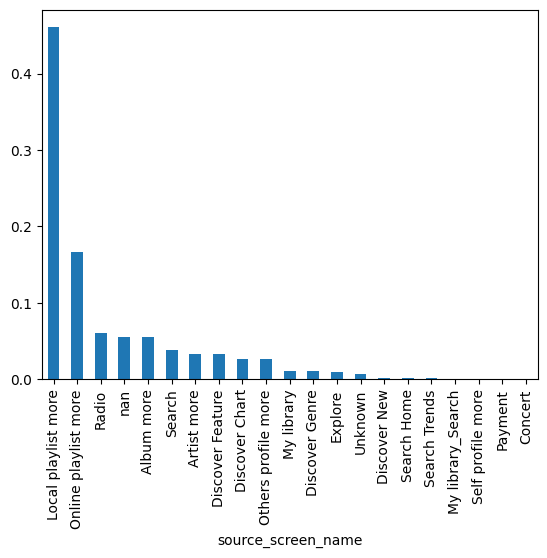

In [4]:
train_df['source_screen_name'].value_counts(normalize=True,
                                            dropna=False).plot(kind='bar')

In [5]:
songs_df.isna().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071358
lyricist       1945306
language             1
dtype: int64

<Axes: xlabel='language'>

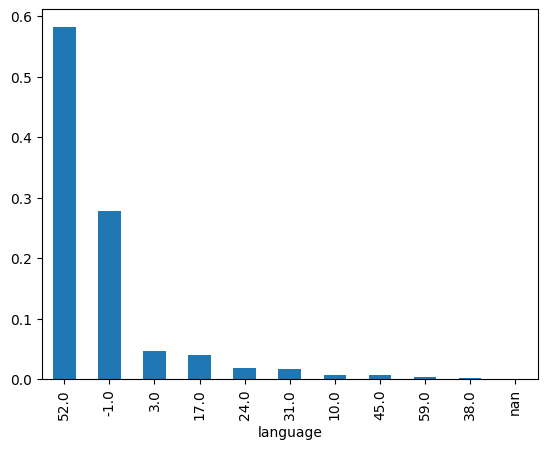

In [6]:
songs_df['language'].value_counts(normalize=True,
                                  dropna=False).plot(kind='bar')

In [13]:
(songs_df['song_length'] / 60000).describe([0.1, 0.5, 0.9]).round(2)

count    2296320.00
mean           4.12
std            2.68
min            0.00
10%            2.29
50%            3.78
90%            5.93
max          202.90
Name: song_length, dtype: float64

In [43]:
members_df.isna().sum()

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

In [67]:
members_df['registration_init_time'].describe([0.25, 0.5, 0.75])

count    3.440300e+04
mean     2.013994e+07
std      2.954015e+04
min      2.004033e+07
25%      2.012103e+07
50%      2.015090e+07
75%      2.016110e+07
max      2.017023e+07
Name: registration_init_time, dtype: float64

In [98]:
reg_col = pd.to_datetime(members_df['registration_init_time'].astype(str))
exp_col = pd.to_datetime(members_df['expiration_date'].astype(str))
reg_col = reg_col.apply(lambda x: np.nan if x < datetime(2005, 10, 1) else x)
exp_col = exp_col.apply(lambda x: np.nan if x >= datetime(2017, 9, 27) else x)
dur_col = (exp_col -
           reg_col).apply(lambda x: np.nan if x <= timedelta(0) else x)

<Axes: ylabel='Frequency'>

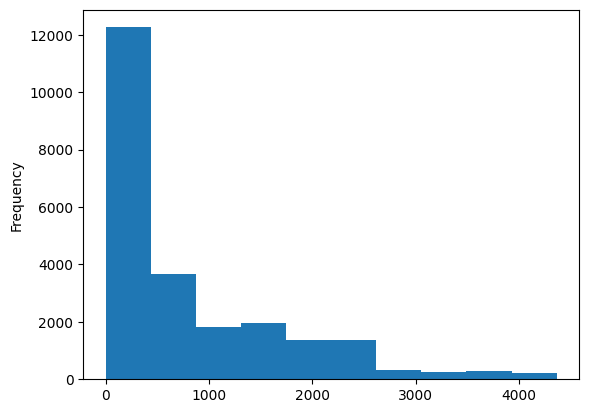

In [106]:
dur_col.apply(lambda x: x.days).plot(kind='hist')

<Axes: ylabel='Frequency'>

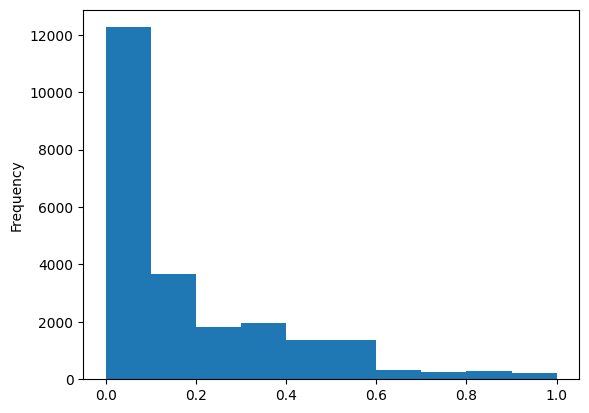

In [115]:
pd.Series(MinMaxScaler().fit_transform(
    dur_col.apply(lambda x: x.days).to_numpy().reshape(
        -1, 1)).reshape(-1)).plot(kind='hist')

In [116]:
dur_col.isna().sum() / len(dur_col)

0.31543760718541985

In [60]:
bd_col = members_df['bd'].apply(lambda x: np.nan if x <= 5 or x >= 75 else x)

In [61]:
bd_col.describe([0.25, 0.5, 0.75])

count    14430.000000
mean        28.851767
std          8.996746
min          7.000000
25%         22.000000
50%         27.000000
75%         34.000000
max         74.000000
Name: bd, dtype: float64

In [63]:
bd_col.isna().sum() / len(bd_col)

0.5805598348981194

<Axes: xlabel='gender'>

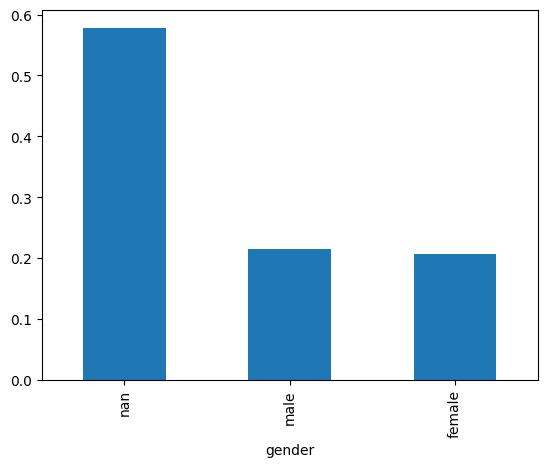

In [45]:
members_df['gender'].value_counts(normalize=True,
                                  dropna=False).plot(kind='bar')

In [124]:
def preprocess_train(train_df: pd.DataFrame):
    """Preprocess train
    
    :param train_df: the train dataframe
    """

    # fill Nan
    train_df['source_system_tab'].fillna('Unknown', inplace=True)
    train_df['source_screen_name'].fillna('Unknown', inplace=True)
    train_df['source_type'].fillna('Unknown', inplace=True)

    # encode
    train_df['source_system_tab'] = LabelEncoder().fit_transform(
        train_df['source_system_tab'])
    train_df['source_screen_name'] = LabelEncoder().fit_transform(
        train_df['source_screen_name'])
    train_df['source_type'] = LabelEncoder().fit_transform(
        train_df['source_type'])


def preprocess_songs(songs_df: pd.DataFrame):
    """Preprocess songs

    :param songs_df: the song dataframe
    """

    # fill Nan
    songs_df['language'] = songs_df['language'].fillna(0.0).astype(str)
    songs_df['genre_ids'].fillna('Unknown', inplace=True)
    songs_df['composer'].fillna(songs_df['artist_name'], inplace=True)
    songs_df['lyricist'].fillna(songs_df['lyricist'], inplace=True)

    # encode & preprocess
    genre2idx = {}

    def map_idx(genre_ls: List[str]):
        for genre in genre_ls:
            if genre not in genre2idx:
                genre2idx[genre] = len(genre2idx) + 1

        return list(map(lambda genre: genre2idx[genre], genre_ls))

    songs_df['genre_ids'] = songs_df['genre_ids'].astype(str).str.split('|')
    songs_df['genre_ids'] = songs_df['genre_ids'].apply(map_idx)

    songs_df['song_length'] = StandardScaler().fit_transform(
        songs_df['song_length'].to_numpy().reshape(-1, 1)).reshape(-1)

    songs_df['artist_name'] = LabelEncoder().fit_transform(
        songs_df['artist_name'])
    songs_df['composer'] = LabelEncoder().fit_transform(songs_df['composer'])
    songs_df['lyricist'] = LabelEncoder().fit_transform(songs_df['lyricist'])
    songs_df['language'] = LabelEncoder().fit_transform(songs_df['language'])


def preprocess_members(members_df: pd.DataFrame):
    """Preprocess members
    
    :param members_df: the member dataframe
    """

    # duration
    members_df['registration_init_time'] = pd.to_datetime(
        members_df['registration_init_time'].astype(str))
    members_df['expiration_date'] = pd.to_datetime(
        members_df['expiration_date'].astype(str))
    members_df['registration_init_time'] = members_df[
        'registration_init_time'].apply(lambda x: np.nan
                                        if x < datetime(2005, 10, 1) else x)
    members_df['expiration_date'] = members_df['expiration_date'].apply(
        lambda x: np.nan if x >= datetime(2017, 9, 27) else x)
    dur_col = (members_df['expiration_date'] -
               members_df['registration_init_time']
               ).apply(lambda x: 0 if x < timedelta(0) else x.days)
    members_df['duration'] = MinMaxScaler().fit_transform(
        dur_col.to_numpy().reshape(-1, 1)).reshape(-1)

    # age
    members_df['bd'] = members_df['bd'].apply(lambda x: np.nan
                                              if x <= 5 or x >= 75 else x)

    # encode
    members_df['city'] = LabelEncoder().fit_transform(members_df['city'])
    members_df['registered_via'] = LabelEncoder().fit_transform(
        members_df['registered_via'])


def padding_genre(split_genre: pd.Series):
    """Pad genres
    
    :param split_genre: a series of lists of genres
    :return: a tensor of size (batch, vocab)
    """

    return pad_sequence(list(map(torch.Tensor, split_genre.tolist())),
                        batch_first=True,
                        padding_value=0)


In [3]:
preprocess_train(train_df)
train_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,2,7,6,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,4,8,5,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,4,8,5,1
3,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,2,7,6,1
4,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,4,8,4,1
...,...,...,...,...,...,...
1844349,TeZ+nhs7OPGhP7IPPn/oT58qjzfi0eQh4rEmW16CvLs=,7dUiqNIuyM+aDRJEw3+ZSYydeZGAQ1AAI0eOd0Nzh8c=,1,11,6,1
1844350,fn9SW/zrdPGYTOKTX1rQG4vXuGjd6fouQ3OL1vfiVAA=,oDa6FWM8MYb6bfrq134wyBy/YkODxg+m7AkVGplizZU=,4,19,10,0
1844351,XlNmaVNn6JTIkYFMGZvx4EMvUblBXrVpFaI+Ablgy7w=,VU8LPqmz8XU8iSIn+d0NxsEuUjEkvQ1khKRgWpU/qRE=,7,1,10,0
1844352,XlNmaVNn6JTIkYFMGZvx4EMvUblBXrVpFaI+Ablgy7w=,+ZXjijLJdny/t5JIuFm4xIlM+bRYKIkaHGDcfDSKfH8=,7,1,10,0


In [4]:
preprocess_songs(songs_df)
songs_df

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,0.004018,[1],214728,438921,92454,5
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,-0.308635,[2],16522,365842,79043,6
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,-0.094535,[1],157034,337001,110924,6
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,0.165054,[1],156251,434979,97976,5
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,-0.662842,[3],219456,387062,82237,9
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,-1.409405,[27],30609,326800,110924,0
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,0.164041,[1],218160,437321,110924,5
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,1.231534,[13],195506,393883,110924,9
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,-0.461872,[1],141978,305370,110924,9


In [5]:
preprocess_members(members_df)
members_df

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,duration
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,0,NaN,NaN,2,2011-08-20,2017-09-20,0.509512
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,0,NaN,NaN,2,2015-06-28,2017-06-22,0.166170
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,0,NaN,NaN,1,2016-04-11,2017-07-12,0.104744
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,0,NaN,NaN,3,2015-09-06,2015-09-07,0.000229
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,0,NaN,NaN,1,2017-01-26,2017-06-13,0.031630
...,...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,0,NaN,NaN,2,2013-11-11,2017-09-10,0.320651
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,2,18.0,male,0,2014-10-24,2017-05-18,0.214760
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,0,NaN,NaN,2,2013-08-02,2017-09-08,0.343342
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,0,NaN,NaN,2,2015-10-20,2017-09-20,0.160669


In [6]:
padding_genre(songs_df['genre_ids'])

tensor([[ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [13.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [39.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [32]:
genre_col = songs_df['genre_ids'].fillna('Unknown')
split_genra = genre_col.astype(str).str.split('|')
split_genra

0           [465]
1           [444]
2           [465]
3           [465]
4           [726]
            ...  
2296315     [958]
2296316     [465]
2296317    [1609]
2296318     [465]
2296319     [829]
Name: genre_ids, Length: 2296320, dtype: object

In [30]:
genre2idx = {}


def map_idx(genre_ls: List[str]):
    for genre in genre_ls:
        if genre not in genre2idx:
            genre2idx[genre] = len(genre2idx) + 1

    return list(map(lambda genre: genre2idx[genre], genre_ls))

In [33]:
split_genra = split_genra.apply(map_idx)

In [36]:
pad_sequence(list(map(torch.Tensor, split_genra.tolist())),
             batch_first=True,
             padding_value=0)

tensor([[ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 3.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [14.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        [40.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [41]:
StandardScaler().fit_transform(songs_df['song_length'].to_numpy().reshape(
    -1, 1))

array([[ 0.00401756],
       [-0.30863472],
       [-0.09453453],
       ...,
       [ 1.23153445],
       [-0.46187237],
       [ 0.14586445]])

In [42]:
songs_df['song_length']

0          247640
1          197328
2          231781
3          273554
4          140329
            ...  
2296315     20192
2296316    273391
2296317    445172
2296318    172669
2296319    270466
Name: song_length, Length: 2296320, dtype: int64

## Train

In [3]:
pp = Preprocesser()
pp.fit_train_test(pd.concat([real_train_df, real_test_df]))
pp.transform_train_test(train_df)
pp.transform_train_test(test_df)
pp.preprocess_songs(songs_df)
pp.preprocess_members(members_df)

In [4]:
tr_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)
tr_song_df = tr_df.merge(songs_df, how='inner', on='song_id')
tr_song_msno_df = tr_song_df.merge(members_df, how='inner', on='msno')
val_song_df = val_df.merge(songs_df, how='inner', on='song_id')
val_song_msno_df = val_song_df.merge(members_df, how='inner', on='msno')

In [5]:
pp.transform_msno_song(tr_song_msno_df)
pp.transform_msno_song(val_song_msno_df)

In [6]:
tr_genre = pp.padding_genre(tr_song_msno_df['genre_ids'])
val_genre = pp.padding_genre(val_song_msno_df['genre_ids'])

In [7]:
sparse_features = [
    'msno', 'song_id', 'source_system_tab', 'source_screen_name',
    'source_type', 'artist_name', 'composer', 'lyricist', 'language', 'city',
    'gender', 'registered_via'
]
dense_features = ['song_length', 'bd', 'duration']
fixlen_feature_columns = [
    SparseFeat(feat, pp.vocab_size[feat], embedding_dim=64)
    for feat in sparse_features
] + [DenseFeat(feat, 1) for feat in dense_features]

varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat('genre_ids',
                                vocabulary_size=len(pp.genre2idx),
                                embedding_dim=64),
                     maxlen=pp.genre_maxlen,
                     combiner='mean')
]

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [8]:
tr_model_input = {name: tr_song_msno_df[name] for name in feature_names}
val_model_input = {name: val_song_msno_df[name] for name in feature_names}
tr_model_input['genre_ids'] = tr_genre
val_model_input['genre_ids'] = val_genre

In [16]:
model = DeepFM(linear_feature_columns,
               dnn_feature_columns,
               task='binary',
               l2_reg_embedding=1e-5,
               device=DEVICE)
model.compile(
    "adagrad",
    "binary_crossentropy",
    metrics=["binary_crossentropy", "auc"],
)

In [17]:
model.fit(tr_model_input,
          tr_song_msno_df['target'].values,
          batch_size=128,
          epochs=10,
          verbose=2,
          validation_data=(val_model_input, val_song_msno_df['target'].values),
          shuffle=True)

cuda
Train on 1475468 samples, validate on 368863 samples, 11528 steps per epoch
Epoch 1/10
790s - loss:  0.5554 - binary_crossentropy:  0.5552 - auc:  0.7834 - val_binary_crossentropy:  0.6587 - val_auc:  0.6831
Epoch 2/10
790s - loss:  0.4947 - binary_crossentropy:  0.4942 - auc:  0.8367 - val_binary_crossentropy:  0.6853 - val_auc:  0.6799
Epoch 3/10
791s - loss:  0.4426 - binary_crossentropy:  0.4419 - auc:  0.8724 - val_binary_crossentropy:  0.7266 - val_auc:  0.6722
Epoch 4/10
790s - loss:  0.4012 - binary_crossentropy:  0.4004 - auc:  0.8962 - val_binary_crossentropy:  0.7798 - val_auc:  0.6650
Epoch 5/10
790s - loss:  0.3723 - binary_crossentropy:  0.3714 - auc:  0.9112 - val_binary_crossentropy:  0.8296 - val_auc:  0.6613
Epoch 6/10
790s - loss:  0.3502 - binary_crossentropy:  0.3492 - auc:  0.9219 - val_binary_crossentropy:  0.8840 - val_auc:  0.6568
Epoch 7/10
790s - loss:  0.3322 - binary_crossentropy:  0.3312 - auc:  0.9300 - val_binary_crossentropy:  0.9318 - val_auc:  0.

In [23]:
tr_model_input.keys()

dict_keys(['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'artist_name', 'composer', 'lyricist', 'language', 'city', 'gender', 'registered_via', 'song_length', 'bd', 'duration', 'genre_ids'])

In [27]:
output = {}
for key in sparse_features:
    output[key] = (tr_model_input[key].min(), tr_model_input[key].max())
output

{'msno': (0, 34402),
 'song_id': (9, 2296292),
 'source_system_tab': (0, 8),
 'source_screen_name': (0, 21),
 'source_type': (0, 12),
 'artist_name': (20, 222357),
 'composer': (12, 447138),
 'lyricist': (0, 110924),
 'language': (0, 10),
 'city': (0, 20),
 'gender': (0, 2),
 'registered_via': (0, 4)}